In [1]:
# ----------------------
# Load required packages
# ----------------------
import copy
import gc
import sys, getopt
import ujson as json
import random
import emcee
import datetime
import corner
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing as mp
from multiprocessing import Pool
from covid19model.models import models
from covid19model.optimization.run_optimization import checkplots, calculate_R0
from covid19model.optimization.objective_fcns import prior_custom, prior_uniform
from covid19model.data import mobility, sciensano, model_parameters
from covid19model.optimization import pso, objective_fcns
from covid19model.models.time_dependant_parameter_fncs import ramp_fun
from covid19model.visualization.output import _apply_tick_locator 
from covid19model.visualization.optimization import autocorrelation_plot, traceplot
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
# ---------
# Load data
# ---------

# Contact matrices
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012')
levels = initN.size
intmat = model_parameters.get_integrated_interaction_matrices()
Nc_all = {'total': intmat['Nc_total'], 'home': intmat['Nc_home'], 'work': intmat['Nc_work'], 'schools': intmat['Nc_schools'], 'transport': intmat['Nc_transport'], 'leisure': intmat['Nc_leisure'], 'others': intmat['Nc_others']}
# Sciensano data
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
# Sciensano mortality data
df_sciensano_mortality = pd.read_csv('../../data/interim/sciensano/sciensano_detailed_mortality.csv', index_col=[0,1])
# Google Mobility data
df_google = mobility.get_google_mobility_data(update=False)
# Define initial states
initial_states = {"S": initN, "E": np.ones(9), "I": np.ones(9)}
# Samples dictionary
with open('../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/BE_WAVE1_R0_COMP_EFF_2021-04-23.json', 'r') as fp:
    samples_dict = json.load(fp)
warmup = int(samples_dict['warmup'])

In [3]:
df_sciensano_mortality.xs(key='80+', level="age_class", drop_level=True)[['cumsum_total','cumsum_hospital','cumsum_nursing']].head()

,cumsum_total,cumsum_hospital,cumsum_nursing
DATE,,,
2020-03-10,1,1.0,0.0
2020-03-11,3,2.0,1.0
2020-03-12,3,2.0,1.0
2020-03-13,5,4.0,1.0
2020-03-14,8,5.0,3.0


In [4]:
residence_time_distributions = pd.read_excel('../../data/interim/model_parameters/COVID19_SEIRD/sciensano_hospital_parameters.xlsx', sheet_name='residence_times', index_col=0, header=[0,1])
samples_dict.update({'residence_times': residence_time_distributions})

In [5]:
bootstrap_fractions = np.load('../../data/interim/model_parameters/COVID19_SEIRD/sciensano_bootstrap_fractions.npy')
# First axis: parameter: c, m0, m0_C, m0_ICU
# Second axis: age group
# Third axis: bootstrap sample
samples_dict.update({'samples_fractions': bootstrap_fractions})

In [6]:
# --------------------------------------
# Time-dependant social contact function
# --------------------------------------

# Extract build contact matrix function
from covid19model.models.time_dependant_parameter_fncs import make_contact_matrix_function, ramp_fun
contact_matrix_4prev, all_contact, all_contact_no_schools = make_contact_matrix_function(df_google, Nc_all)

# Define policy function
def policies_wave1(t, states, param, l, prev_schools, prev_work, prev_rest, prev_home):

    # Convert time to timestamp
    t = pd.Timestamp(t.date())

    # Convert l to a date
    l_days = pd.Timedelta(l, unit='D')

    # Define additional dates where intensity or school policy changes
    t1 = pd.Timestamp('2020-03-15') # start of lockdown
    t2 = pd.Timestamp('2020-05-15') # gradual re-opening of schools (assume 50% of nominal scenario)
    t3 = pd.Timestamp('2020-07-01') # start of summer holidays
    t4 = pd.Timestamp('2020-08-07') # end of 'second wave' in antwerp
    t5 = pd.Timestamp('2020-09-01') # end of summer holidays

    if t <= t1:
        return all_contact(t)
    elif t1 < t <= t1 + l_days:
        policy_old = all_contact(t)
        policy_new = contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                    school=0)
        return ramp_fun(policy_old, policy_new, t, t1, l)
    elif t1 + l_days < t <= t2:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
    elif t2 < t <= t3:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
    ## WARNING: During the summer of 2020, highly localized clusters appeared in Antwerp city, and lockdown measures were taken locally
    ## Do not forget this is a national-level model, you need a spatially explicit model to correctly model localized phenomena.
    ## The following is an ad-hoc tweak to assure a fit on the data during summer in order to be as accurate as possible with the seroprelevance
    elif t3 < t <= t3 + l_days:
        policy_old = contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, school=0)
        policy_new = contact_matrix_4prev(t, prev_home, prev_schools, prev_work, 0.80, school=0)
        return ramp_fun(policy_old, policy_new, t, t3, l)
    elif t3 + l_days < t <= t4:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, 0.80, school=0)
    elif t4 < t <= t5:
        return contact_matrix_4prev(t, prev_home, prev_schools, 0.05, 0.05, 
                              school=0)                                          
    else:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, school=1)


# ------------------------------
# Function to add binomial draws
# ------------------------------

def add_poisson(state_name, output, n_samples, n_draws_per_sample, UL=1-0.05*0.5, LL=0.05*0.5):
    data = output[state_name].sum(dim="Nc").values
    # Initialize vectors
    vector = np.zeros((data.shape[1],n_draws_per_sample*n_samples))
    # Loop over dimension draws
    for n in range(data.shape[0]):
        binomial_draw = np.random.poisson( np.expand_dims(data[n,:],axis=1),size = (data.shape[1],n_draws_per_sample))
        vector[:,n*n_draws_per_sample:(n+1)*n_draws_per_sample] = binomial_draw
    # Compute mean and median
    mean = np.mean(vector,axis=1)
    median = np.median(vector,axis=1)    
    # Compute quantiles
    LL = np.quantile(vector, q = LL, axis = 1)
    UL = np.quantile(vector, q = UL, axis = 1)
    return mean, median, LL, UL

# ------------------------
# Define sampling function
# ------------------------

def draw_fcn(param_dict,samples_dict):
    # Calibrated samples
    idx, param_dict['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    param_dict['da'] = samples_dict['da'][idx]
    param_dict['l'] = samples_dict['l'][idx] 
    param_dict['prev_home'] = samples_dict['prev_home'][idx]      
    param_dict['prev_work'] = samples_dict['prev_work'][idx]       
    param_dict['prev_rest'] = samples_dict['prev_rest'][idx]
    param_dict['zeta'] = samples_dict['zeta'][idx]
    # Hospitalization fractions using bootstrapped samples
    names = ['c','m_C','m_ICU']
    for idx,name in enumerate(names):
        par=[]
        for jdx in range(9):
            par.append(np.random.choice(samples_dict['samples_fractions'][idx,jdx,:]))
        param_dict[name] = np.array(par)
    # Hospitalization residence times using parametric bootstrap
    n=30
    distributions = [samples_dict['residence_times']['d_transfer'],
                     samples_dict['residence_times']['dC_R'],
                     samples_dict['residence_times']['dC_D'],
                     samples_dict['residence_times']['dICU_R'],
                     samples_dict['residence_times']['dICU_D']]
    names = ['d_transfer', 'dc_R', 'dc_D', 'dICU_R', 'dICU_D']
    for idx,dist in enumerate(distributions):
        param_val=[]
        for age_group in dist.index.get_level_values(0).unique().values[0:-1]:
            draw = np.random.gamma(dist['shape'].loc[age_group],scale=dist['scale'].loc[age_group],size=n)
            param_val.append(np.mean(draw))
        param_dict[names[idx]] = np.array(param_val)
    return param_dict

In [7]:
# ----------------------------------------
# Initialize the model without vaccination
# ----------------------------------------

# Load the model parameters dictionary
params = model_parameters.get_COVID19_SEIRD_parameters()
params.update({'l': 21, 'prev_schools': 0, 'prev_work': 0.5, 'prev_rest': 0.5,
               'prev_home': 0.5})
# Initialize model
model = models.COVID19_SEIRD(initial_states, params,time_dependent_parameters={'Nc': policies_wave1})

In [8]:
start_sim = '2020-03-15'
end_sim = '2020-07-08'
start_calibration = start_sim
end_calibration = end_sim
n_samples=30
n_draws=1

In [9]:
out = model.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict)
mean_Hin, median_Hin, LL_Hin, UL_Hin = add_poisson('H_in', out, n_samples, n_draws)
mean_Htot, median_Htot, LL_Htot, UL_Htot = add_poisson('H_tot', out, n_samples, n_draws)
mean_ICU, median_ICU, LL_ICU, UL_ICU = add_poisson('ICU', out, n_samples, n_draws)
mean_D, median_D, LL_D, UL_D = add_poisson('D', out, n_samples, n_draws)
simtime = pd.to_datetime(out['time'].values)

In [10]:
for idx,age_group in enumerate(df_sciensano_mortality.index.get_level_values(0).unique().values):
    if idx == 0:
        total_deaths_hospital = df_sciensano_mortality.xs(key=age_group, level="age_class", drop_level=True)[['cumsum_hospital']].values
    else:
        total_deaths_hospital = total_deaths_hospital + df_sciensano_mortality.xs(key=age_group, level="age_class", drop_level=True)[['cumsum_hospital']].values
        
deaths_hospital = pd.Series(data=np.squeeze(total_deaths_hospital), index=df_sciensano_mortality.index.get_level_values(1).unique())

Text(0, 0.5, '$D_{tot}$ (-)')

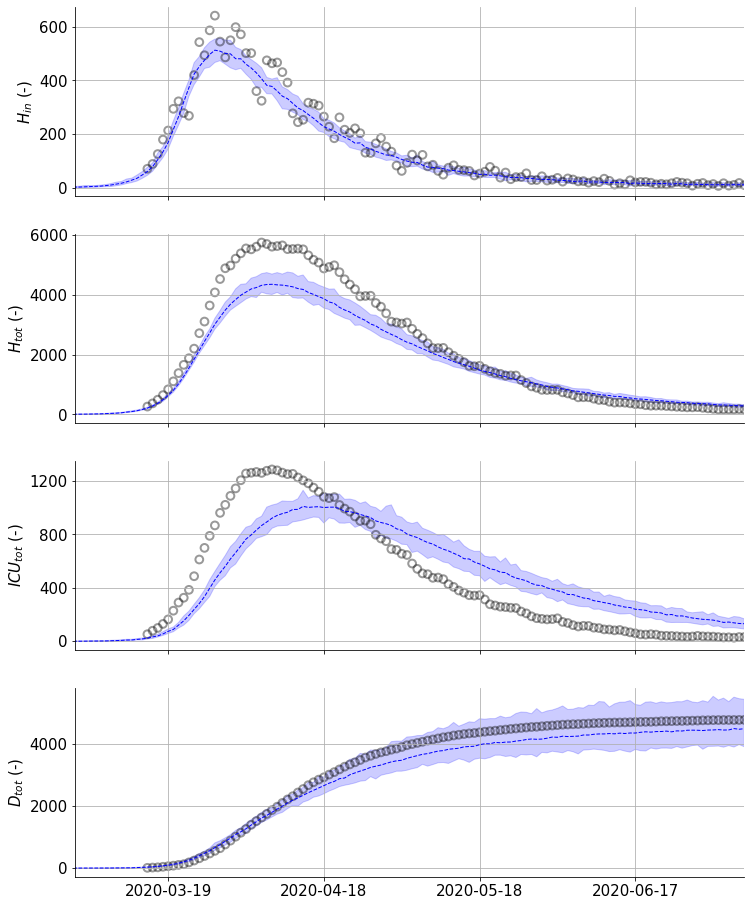

In [11]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(nrows=4,ncols=1,figsize=(12,16),sharex=True)

ax1.plot(simtime, mean_Hin,'--', color='blue', linewidth=1)
ax1.fill_between(simtime, LL_Hin, UL_Hin, alpha=0.20, color = 'blue')
ax1.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['H_in'][start_calibration:end_calibration], color='black', alpha=0.4, linestyle='None', facecolors='none', s=60, linewidth=2)
ax1.scatter(df_sciensano[pd.to_datetime(end_calibration)+datetime.timedelta(days=1):end_sim].index,df_sciensano['H_in'][pd.to_datetime(end_calibration)+datetime.timedelta(days=1):end_sim], color='red', alpha=0.4, linestyle='None', facecolors='none', s=60, linewidth=2)

ax1 = _apply_tick_locator(ax1)
ax1.set_ylabel('$H_{in}$ (-)')

ax2.plot(simtime, mean_Htot,'--', color='blue', linewidth=1)
ax2.fill_between(simtime, LL_Htot, UL_Htot, alpha=0.20, color = 'blue')
ax2.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['H_tot'][start_calibration:end_calibration], color='black', alpha=0.4, linestyle='None', facecolors='none', s=60, linewidth=2)
ax2.scatter(df_sciensano[pd.to_datetime(end_calibration)+datetime.timedelta(days=1):end_sim].index,df_sciensano['H_tot'][pd.to_datetime(end_calibration)+datetime.timedelta(days=1):end_sim], color='red', alpha=0.4, linestyle='None', facecolors='none', s=60, linewidth=2)

ax2 = _apply_tick_locator(ax2)
ax2.set_ylabel('$H_{tot}$ (-)')

ax3.plot(simtime, mean_ICU,'--', color='blue', linewidth=1)
ax3.fill_between(simtime, LL_ICU, UL_ICU, alpha=0.20, color = 'blue')
ax3.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['ICU_tot'][start_calibration:end_calibration], color='black', alpha=0.4, linestyle='None', facecolors='none', s=60, linewidth=2)
ax3.scatter(df_sciensano[pd.to_datetime(end_calibration)+datetime.timedelta(days=1):end_sim].index,df_sciensano['ICU_tot'][pd.to_datetime(end_calibration)+datetime.timedelta(days=1):end_sim], color='red', alpha=0.4, linestyle='None', facecolors='none', s=60, linewidth=2)

ax3 = _apply_tick_locator(ax3)
ax3.set_ylabel('$ICU_{tot}$ (-)')

ax4.plot(simtime, mean_D,'--', color='blue', linewidth=1)
ax4.fill_between(simtime, LL_D, UL_D, alpha=0.20, color = 'blue')
ax4.scatter(deaths_hospital[start_calibration:end_calibration].index,deaths_hospital[start_calibration:end_calibration], color='black', alpha=0.4, linestyle='None', facecolors='none', s=60, linewidth=2)

ax4 = _apply_tick_locator(ax4)
ax4.set_xlim('2020-03-01',end_sim)
ax4.set_ylabel('$D_{tot}$ (-)')

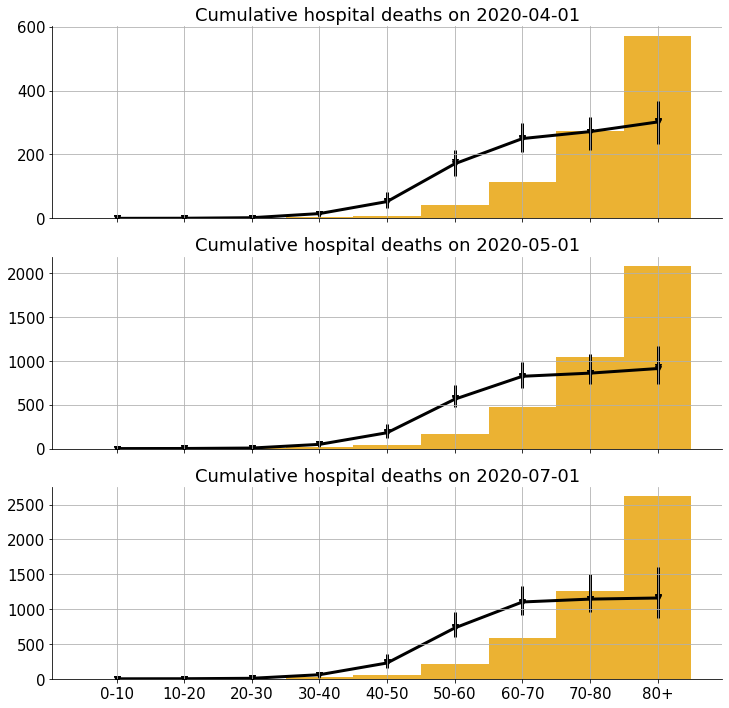

In [12]:
dates = ['2020-04-01','2020-05-01','2020-07-01']

fig,axes = plt.subplots(nrows=len(dates),ncols=1,figsize=(12,4*len(dates)),sharex=True)
for idx,date in enumerate(dates):
    data_sciensano = []
    for jdx,age_group in enumerate(df_sciensano_mortality.index.get_level_values(0).unique().values):
        data_sciensano.append(df_sciensano_mortality.xs(key=age_group, level="age_class", drop_level=True).loc[dates[idx],'cumsum_hospital'])
    
    axes[idx].scatter(df_sciensano_mortality.index.get_level_values(0).unique().values,out['D'].mean(dim='draws').loc[dict(time=date)],color='black',marker='v',zorder=1)
    yerr = np.zeros([2,len(out['D'].quantile(dim='draws',q=0.975).loc[dict(time=date)].values)])
    yerr[0,:] = out['D'].mean(dim='draws').loc[dict(time=date)] - out['D'].quantile(dim='draws',q=0.025).loc[dict(time=date)].values
    yerr[1,:] = out['D'].quantile(dim='draws',q=0.975).loc[dict(time=date)].values - out['D'].mean(dim='draws').loc[dict(time=date)]
    axes[idx].errorbar(x=df_sciensano_mortality.index.get_level_values(0).unique().values,
                       y=out['D'].median(dim='draws').loc[dict(time=date)],
                       yerr=yerr,
                       color = 'black', marker = 'v', zorder=1)
    axes[idx].bar(df_sciensano_mortality.index.get_level_values(0).unique().values,data_sciensano,width=1,alpha=0.8,zorder=0)
    axes[idx].set_title('Cumulative hospital deaths on '+date)